## Final Project Submission

Please fill out:
* Student name: Kai Graham
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!
# Predict housing prices to be used by PE shop looking for valuation help.

In [2]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/Users/kai_graham/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# import dataset

data = pd.read_csv('kc_house_data.csv')

In [4]:
# look at dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
# look at price to get a sense of what we want to predict and its distribution, etc.
data['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

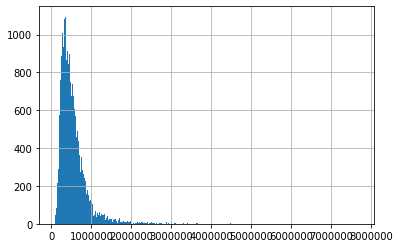

In [6]:
data['price'].hist(bins='auto')

In [7]:
# how many entries have a price greater than 1M
data.loc[data['price'] > 1000000]['price'].count()

1458

In [8]:
# Check 3 standard deviation cutoff for housing limit
three_stds = data['price'].std() * 3
three_stds

1102104.4203041834

In [9]:
# high point
high_point = data['price'].median() + three_stds
round(high_point, 2)

1552104.42

In [10]:
# remove all houses with prices greater than the identified high point
houses_data = data.loc[data['price'] <= high_point]

In [11]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21114 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21114 non-null  int64  
 1   date           21114 non-null  object 
 2   price          21114 non-null  float64
 3   bedrooms       21114 non-null  int64  
 4   bathrooms      21114 non-null  float64
 5   sqft_living    21114 non-null  int64  
 6   sqft_lot       21114 non-null  int64  
 7   floors         21114 non-null  float64
 8   waterfront     18786 non-null  float64
 9   view           21053 non-null  float64
 10  condition      21114 non-null  int64  
 11  grade          21114 non-null  int64  
 12  sqft_above     21114 non-null  int64  
 13  sqft_basement  21114 non-null  object 
 14  yr_built       21114 non-null  int64  
 15  yr_renovated   17360 non-null  float64
 16  zipcode        21114 non-null  int64  
 17  lat            21114 non-null  float64
 18  long  

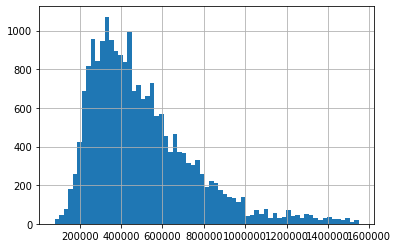

In [12]:
# look at the histogram
houses_data['price'].hist(bins='auto')

In [13]:
houses_data['price'].describe()

count    2.111400e+04
mean     5.030432e+05
std      2.514620e+05
min      7.800000e+04
25%      3.200000e+05
50%      4.450000e+05
75%      6.250000e+05
max      1.550000e+06
Name: price, dtype: float64

The median house price is still relatively inline with where it was before removing the upper set of houses

In [14]:
houses_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [15]:
# remove ID column as it is not relevant
houses_data = houses_data.drop(columns='id')

In [16]:
houses_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [17]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21114 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21114 non-null  object 
 1   price          21114 non-null  float64
 2   bedrooms       21114 non-null  int64  
 3   bathrooms      21114 non-null  float64
 4   sqft_living    21114 non-null  int64  
 5   sqft_lot       21114 non-null  int64  
 6   floors         21114 non-null  float64
 7   waterfront     18786 non-null  float64
 8   view           21053 non-null  float64
 9   condition      21114 non-null  int64  
 10  grade          21114 non-null  int64  
 11  sqft_above     21114 non-null  int64  
 12  sqft_basement  21114 non-null  object 
 13  yr_built       21114 non-null  int64  
 14  yr_renovated   17360 non-null  float64
 15  zipcode        21114 non-null  int64  
 16  lat            21114 non-null  float64
 17  long           21114 non-null  float64
 18  sqft_l

In [18]:
# handle missing values - - view, waterfront, yr_renovated are the only columns missing values
houses_data['waterfront'].nunique()

2

In [19]:
houses_data['waterfront'].unique()

array([nan,  0.,  1.])

In [20]:
# check how many are missing
houses_data['waterfront'].isna().sum()

2328

In [21]:
# 11% of the data is NaN, don't want to drop this many rows - - set all NaNs as 0

In [22]:
# assuming that NaNs in the waterfront column are related to houses that do not have waterfront
# will relabel all NaNs as 0
houses_data['waterfront'] = houses_data['waterfront'].fillna(value=0.)

In [23]:
# check there are no more missing values
houses_data['waterfront'].isna().any()

False

In [24]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21114 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21114 non-null  object 
 1   price          21114 non-null  float64
 2   bedrooms       21114 non-null  int64  
 3   bathrooms      21114 non-null  float64
 4   sqft_living    21114 non-null  int64  
 5   sqft_lot       21114 non-null  int64  
 6   floors         21114 non-null  float64
 7   waterfront     21114 non-null  float64
 8   view           21053 non-null  float64
 9   condition      21114 non-null  int64  
 10  grade          21114 non-null  int64  
 11  sqft_above     21114 non-null  int64  
 12  sqft_basement  21114 non-null  object 
 13  yr_built       21114 non-null  int64  
 14  yr_renovated   17360 non-null  float64
 15  zipcode        21114 non-null  int64  
 16  lat            21114 non-null  float64
 17  long           21114 non-null  float64
 18  sqft_l

In [25]:
# look at yr_renovated
houses_data['yr_renovated'].nunique()

70

In [26]:
houses_data['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1970., 1989., 2004.,
       1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971., 1979.,
       1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008., 1968.,
       2012., 1963., 1951., 1962., 1953., 1993., 1998., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

In [27]:
# fill NaNs with 0. -- assuming these did not receive a reno
houses_data['yr_renovated'] = houses_data['yr_renovated'].fillna(value=0.)

In [28]:
# should be no more missing values
houses_data.isna().any()

date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view              True
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [29]:
# view is missing some values - - how many are missing?
houses_data['view'].isna().sum()

61

In [30]:
# only 61 are missing - - remove all entries without view
houses_data['view'].unique()

array([ 0., nan,  3.,  2.,  4.,  1.])

In [31]:
houses_data = houses_data.dropna()

In [32]:
houses_data.isna().any()

date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [33]:
# no more missing values - - check for duplicates
houses_data.duplicated().any()

False

In [34]:
# no duplicates

In [35]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21053 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21053 non-null  object 
 1   price          21053 non-null  float64
 2   bedrooms       21053 non-null  int64  
 3   bathrooms      21053 non-null  float64
 4   sqft_living    21053 non-null  int64  
 5   sqft_lot       21053 non-null  int64  
 6   floors         21053 non-null  float64
 7   waterfront     21053 non-null  float64
 8   view           21053 non-null  float64
 9   condition      21053 non-null  int64  
 10  grade          21053 non-null  int64  
 11  sqft_above     21053 non-null  int64  
 12  sqft_basement  21053 non-null  object 
 13  yr_built       21053 non-null  int64  
 14  yr_renovated   21053 non-null  float64
 15  zipcode        21053 non-null  int64  
 16  lat            21053 non-null  float64
 17  long           21053 non-null  float64
 18  sqft_l

In [36]:
# handle strings - - convert to appropriate types
houses_data['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '700.0', '820.0', '780.0', '790.0', '330.0',
       '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0', '600.0',
       '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0', '880.0',
       '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0', '840.0',
       '380.0', '770.0', '480.0', '570.0', '1490.0', '620.0', '1250.0',
       '1270.0', '120.0', '650.0', '180.0', '1130.0', '450.0', '1460.0',
       '1020.0', '1030.0', '750.0', '640.0', '1070.0', '490.0', '1310.0',
       '630.0', '2000.0', '390.0', '430.0', '210.0', '1430.0', '1950.0',
       '440.0', '220.0', '1160.0', '860.0', '580.0', '2060.0', '1180.0',
       '200.0', '1150.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0',
       '960.0', '870.0', '280.0', '1200.0', '1100.0', '460.0', '1400.0',
       '720.0', '660.0', '1220.0', '900.0', '420.0', '1580.0', '1380.0',
       '475.0', '690.0', '270.0', '350.0', '935.0', '7

In [37]:
# need to remove the entries with ?
# check how many there are
houses_data.loc[houses_data['sqft_basement'] == '?']['price'].count()

446

In [38]:
# only 446 entries out of ~20,000 - - remove these
houses_data = houses_data.loc[houses_data['sqft_basement'] != '?']

In [39]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20607 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20607 non-null  object 
 1   price          20607 non-null  float64
 2   bedrooms       20607 non-null  int64  
 3   bathrooms      20607 non-null  float64
 4   sqft_living    20607 non-null  int64  
 5   sqft_lot       20607 non-null  int64  
 6   floors         20607 non-null  float64
 7   waterfront     20607 non-null  float64
 8   view           20607 non-null  float64
 9   condition      20607 non-null  int64  
 10  grade          20607 non-null  int64  
 11  sqft_above     20607 non-null  int64  
 12  sqft_basement  20607 non-null  object 
 13  yr_built       20607 non-null  int64  
 14  yr_renovated   20607 non-null  float64
 15  zipcode        20607 non-null  int64  
 16  lat            20607 non-null  float64
 17  long           20607 non-null  float64
 18  sqft_l

In [40]:
# now need to convert basement column to a number format
houses_data['sqft_basement'] = houses_data['sqft_basement'].astype('float64')

In [41]:
houses_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20607 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20607 non-null  object 
 1   price          20607 non-null  float64
 2   bedrooms       20607 non-null  int64  
 3   bathrooms      20607 non-null  float64
 4   sqft_living    20607 non-null  int64  
 5   sqft_lot       20607 non-null  int64  
 6   floors         20607 non-null  float64
 7   waterfront     20607 non-null  float64
 8   view           20607 non-null  float64
 9   condition      20607 non-null  int64  
 10  grade          20607 non-null  int64  
 11  sqft_above     20607 non-null  int64  
 12  sqft_basement  20607 non-null  float64
 13  yr_built       20607 non-null  int64  
 14  yr_renovated   20607 non-null  float64
 15  zipcode        20607 non-null  int64  
 16  lat            20607 non-null  float64
 17  long           20607 non-null  float64
 18  sqft_l

In [42]:
"""
Function to plot y vs. a chosen set of x variables
"""

def plot_x_y(x_vals, y_val, data=houses_data):
    fig, axes = plt.subplots(nrows = 1, ncols=len(x_vals), figsize=(20,5))
    for xcol, ax in zip(x_vals, axes):
        data.plot(kind='scatter', x=xcol, y=y_val, ax=ax, alpha=0.5)
    plt.tight_layout()
    plt.show()

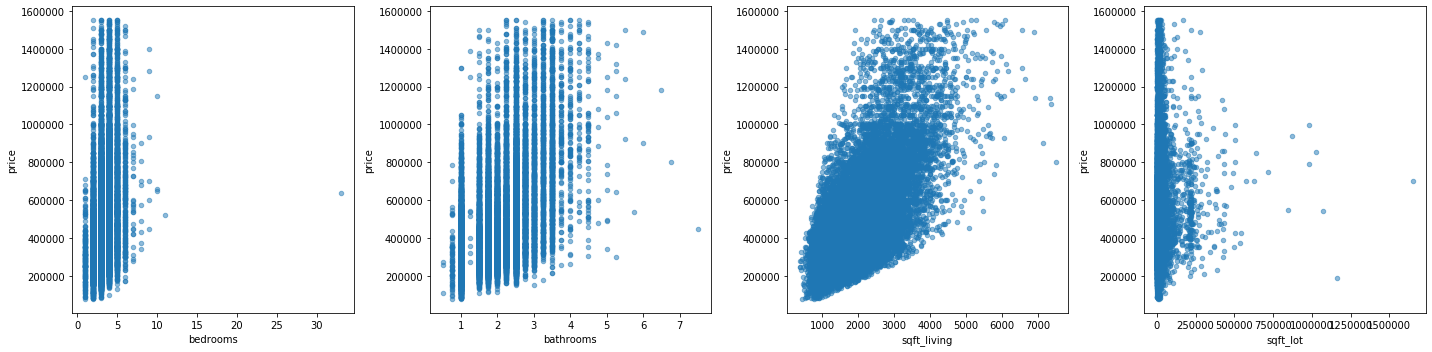

In [43]:
plot_x_y(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], 'price')

In [44]:
# deal with outliers -- there are som significant outliers seen, specifically in bedrooms and sqft_lot

houses_data.loc[houses_data['bedrooms'] >= 7]['price'].count()

50

In [45]:
# only 290 entries have bedrooms greater than 7 - - remove these
houses_data = houses_data.loc[houses_data['bedrooms'] < 7]

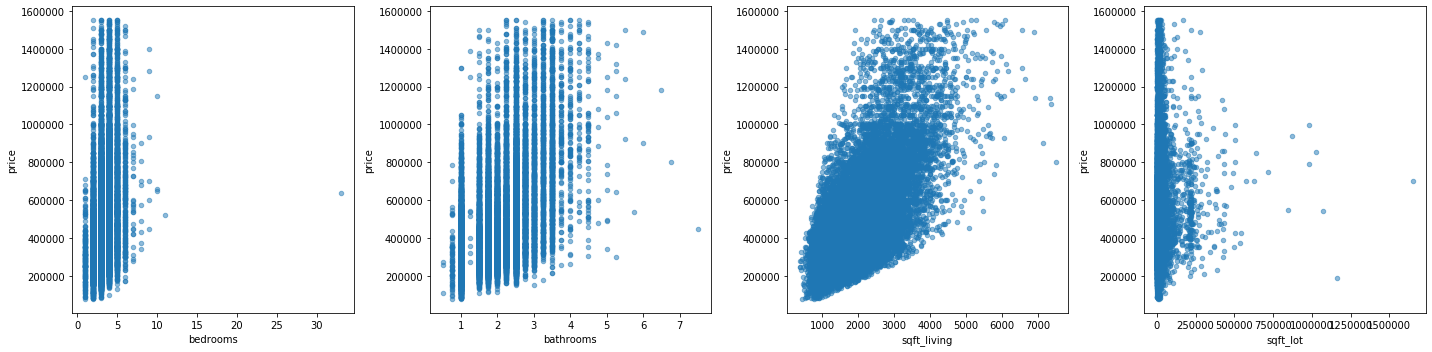

In [46]:
# replot
plot_x_y(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], 'price')

In [47]:
# how many total entries do we have left?
len(houses_data)

20557

In [48]:
# distributions are looking much better now - - there are still some funky data points within sqft_lot
houses_data['sqft_lot'].describe()

count    2.055700e+04
mean     1.476555e+04
std      4.013215e+04
min      5.200000e+02
25%      5.002000e+03
50%      7.560000e+03
75%      1.046000e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

In [49]:
# how many houses have more than 50k sqft lot
houses_data.loc[houses_data['sqft_lot'] > 50000]['price'].count()

824

In [50]:
# only a small number - - going to remove these entries
houses_data = houses_data.loc[houses_data['sqft_lot'] <= 50000]

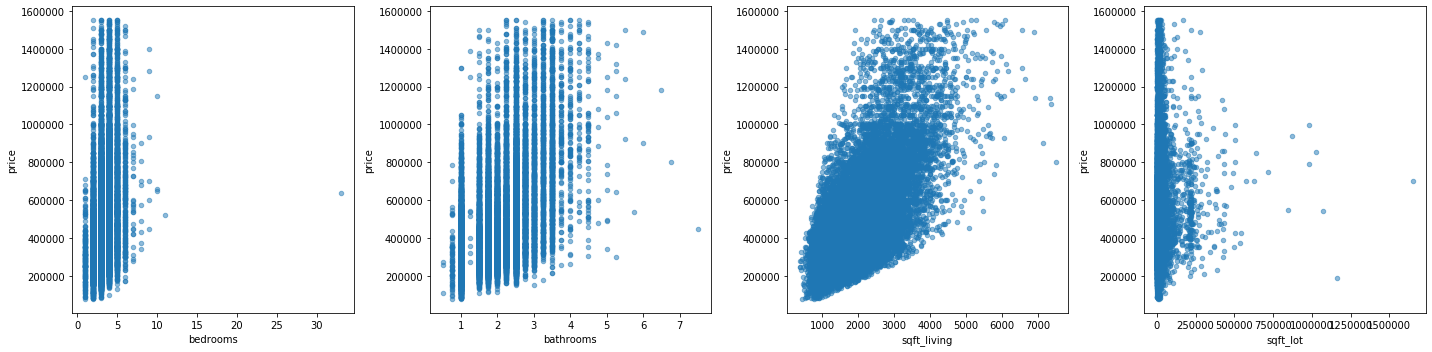

In [51]:
# replot
plot_x_y(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot'], 'price')

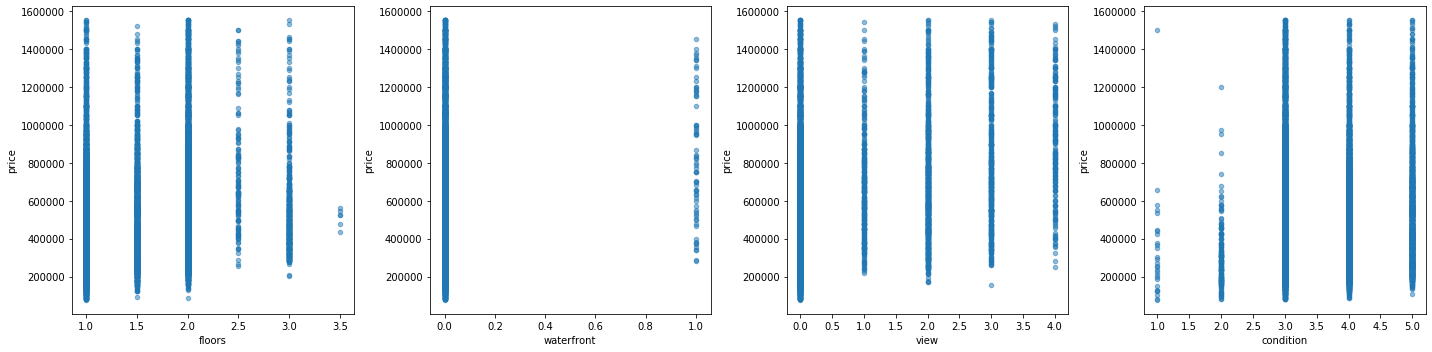

In [52]:
plot_x_y(['floors', 'waterfront', 'view', 'condition'], 'price')

In [53]:
# check how many entries have more than 3 floors

houses_data.loc[houses_data['floors'] > 3]['price'].count()


6

In [54]:
# given there are only 6, remove these
houses_data = houses_data.loc[houses_data['floors'] <= 3]

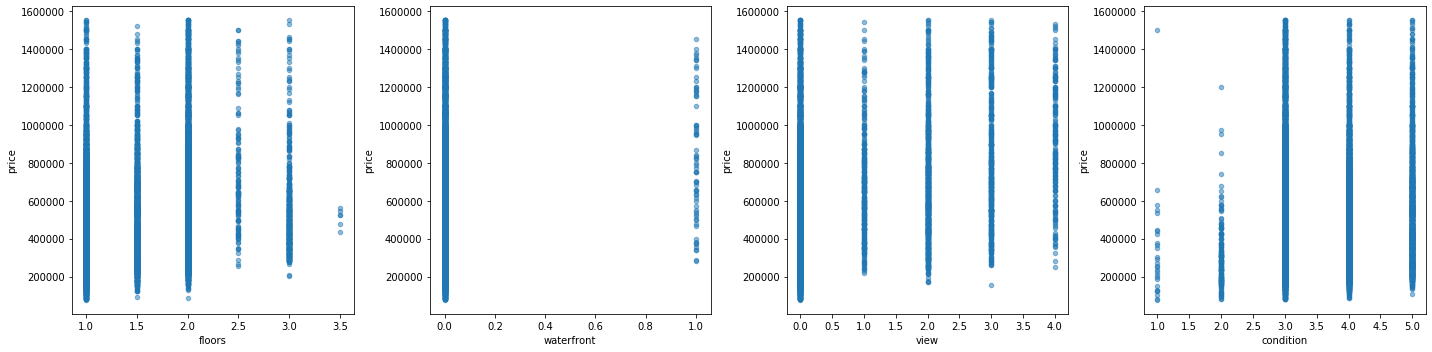

In [55]:
# replot
plot_x_y(['floors', 'waterfront', 'view', 'condition'], 'price')

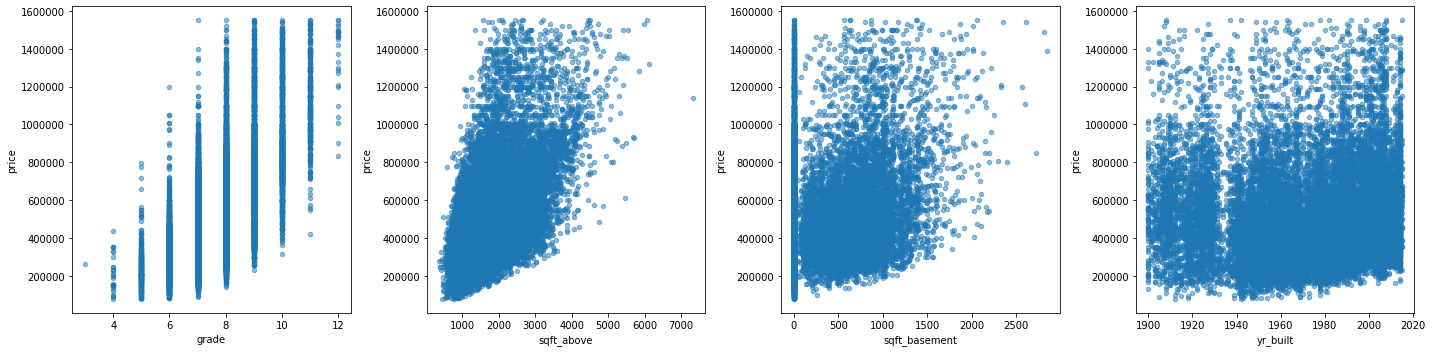

In [56]:
plot_x_y(['grade', 'sqft_above', 'sqft_basement', 'yr_built'], 'price')

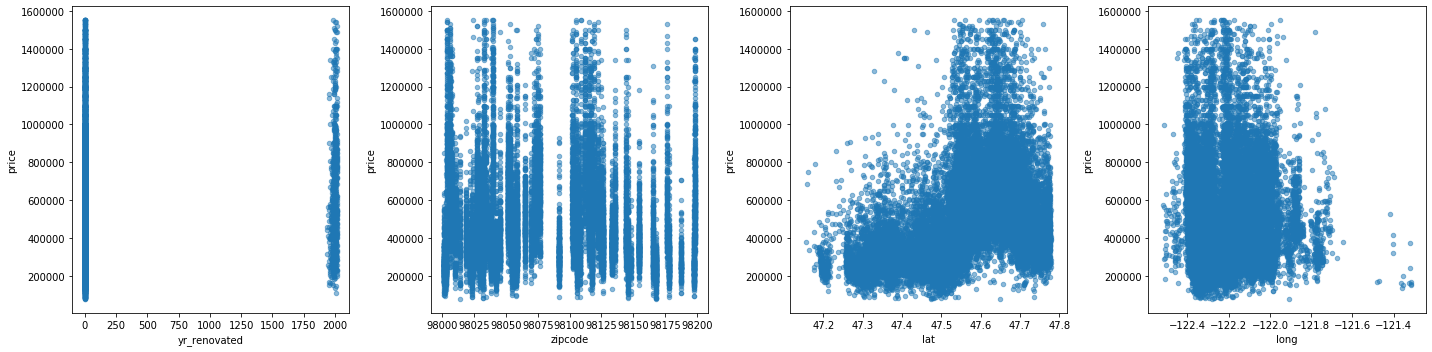

In [57]:
plot_x_y(['yr_renovated', 'zipcode', 'lat', 'long'], 'price')

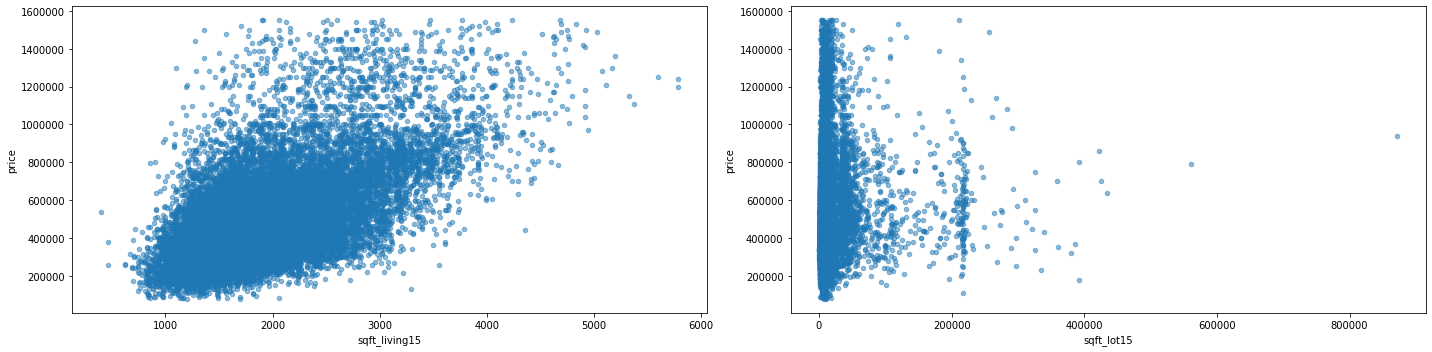

In [58]:
plot_x_y(['sqft_living15', 'sqft_lot15'], 'price')

In [59]:
# replot all against price
houses_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

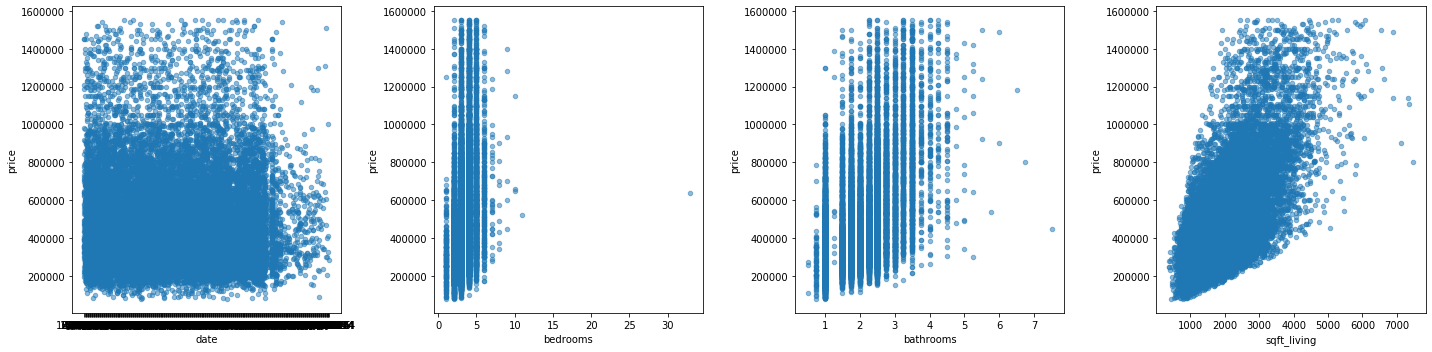

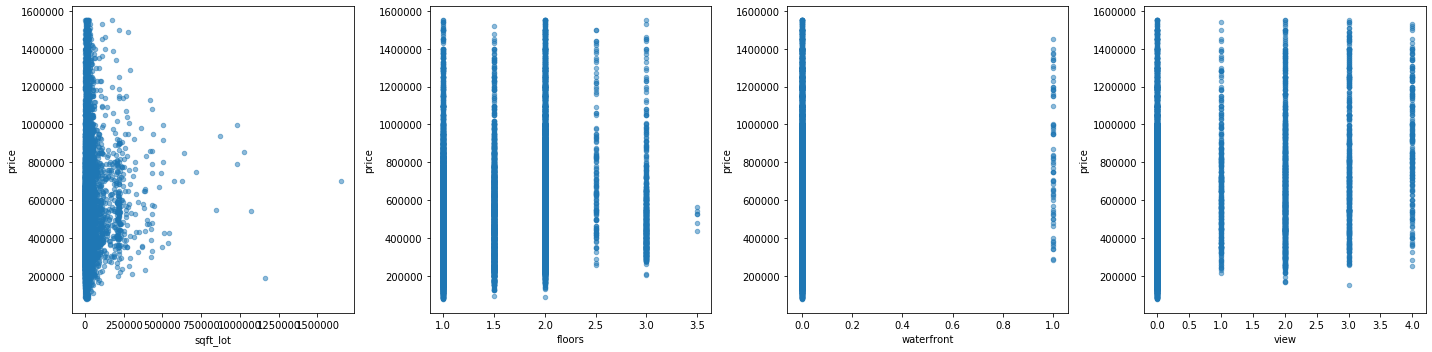

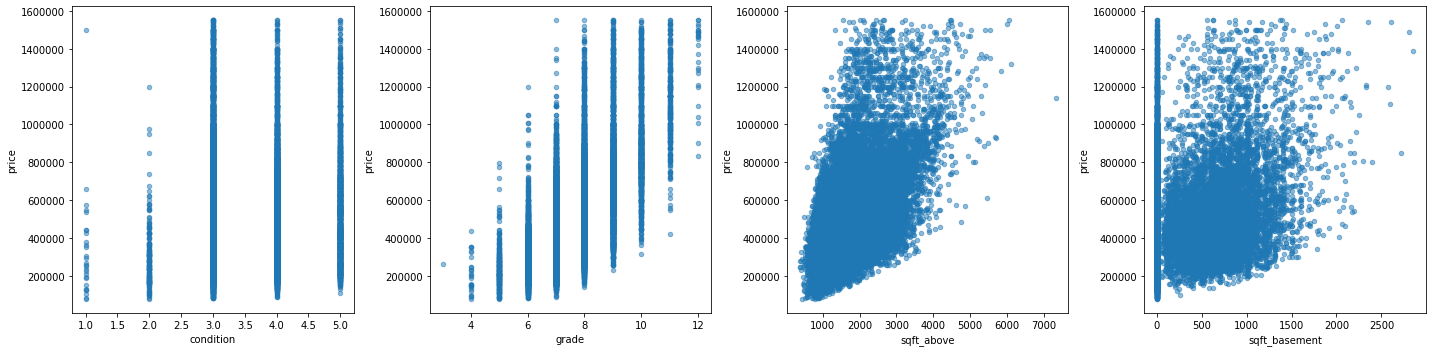

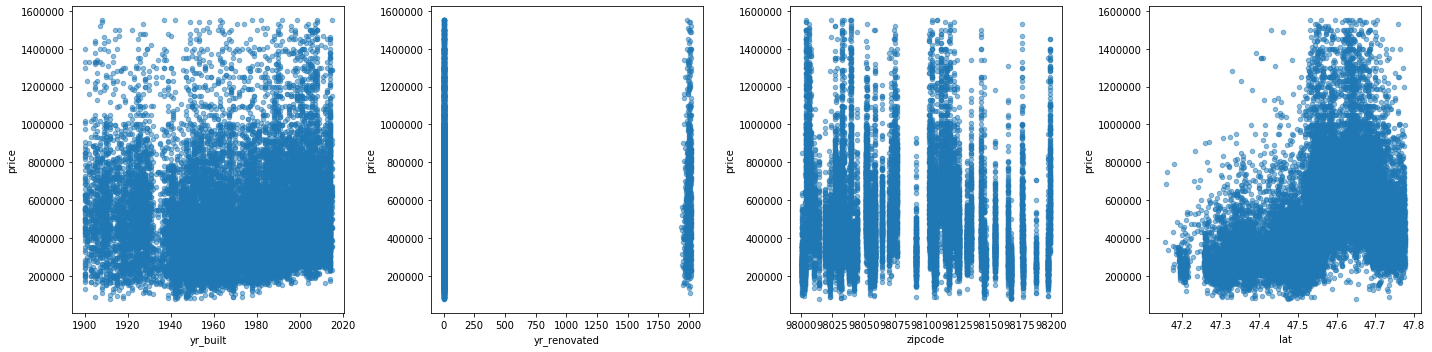

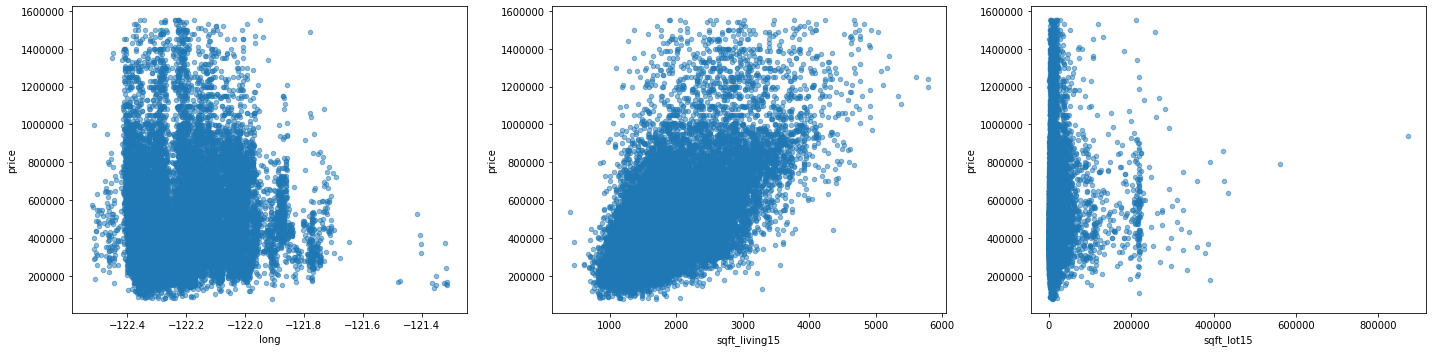

In [60]:
plot_x_y(['date', 'bedrooms', 'bathrooms', 'sqft_living'], 'price')
plot_x_y(['sqft_lot', 'floors', 'waterfront', 'view'], 'price')
plot_x_y(['condition', 'grade', 'sqft_above', 'sqft_basement'], 'price')
plot_x_y(['yr_built', 'yr_renovated', 'zipcode', 'lat'], 'price')
plot_x_y(['long', 'sqft_living15', 'sqft_lot15'], 'price')

In [61]:
# clean up sqft_lot
houses_data['sqft_lot'].describe()

count    19727.000000
mean      9046.589243
std       7532.774888
min        520.000000
25%       5000.000000
50%       7403.000000
75%       9975.500000
max      49936.000000
Name: sqft_lot, dtype: float64

In [62]:
# how many have a lot size of ~10K or higher?
houses_data.loc[houses_data['sqft_lot'] >= (10**4)]['price'].count()

4909

In [63]:
three_stds = houses_data['sqft_lot'].std() * 3

In [64]:
# high point
high_mark = houses_data['sqft_lot'].median() + three_stds
high_mark

30001.324663208656

In [65]:
# remove entries above this amount - - check how many there are
houses_data.loc[houses_data['sqft_lot'] >= high_mark]['price'].count()

751

In [66]:
houses_data = houses_data.loc[houses_data['sqft_lot'] < high_mark]

In [67]:
houses_data.loc[houses_data['sqft_lot'] >= high_mark]['price'].count()

0

In [68]:
# replot

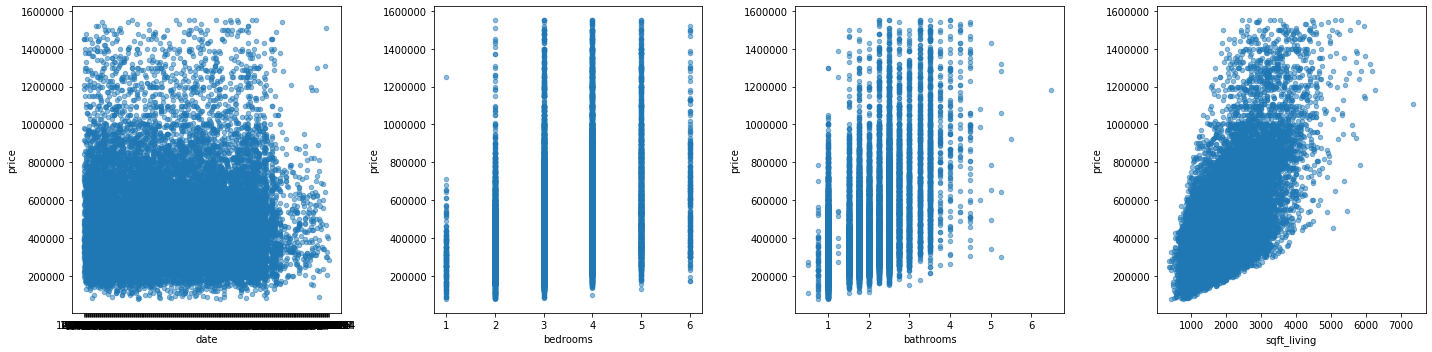

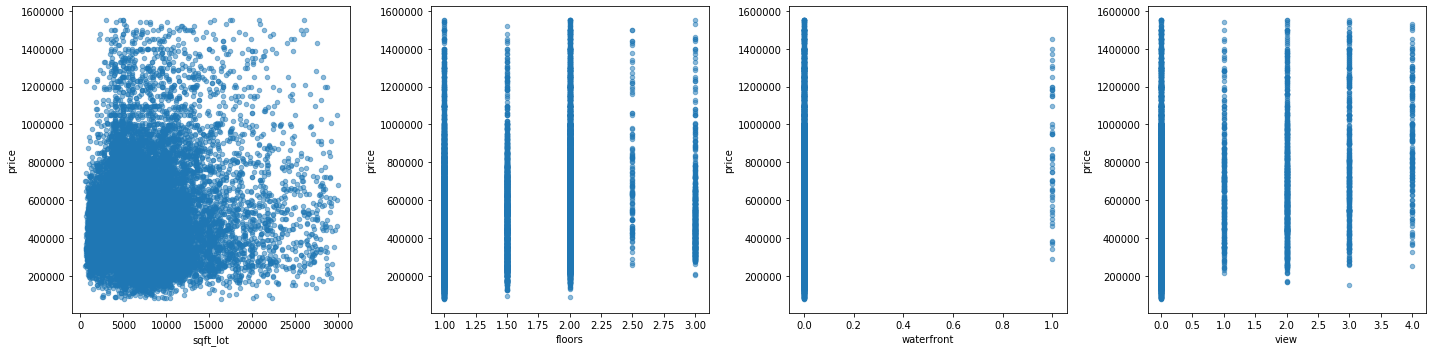

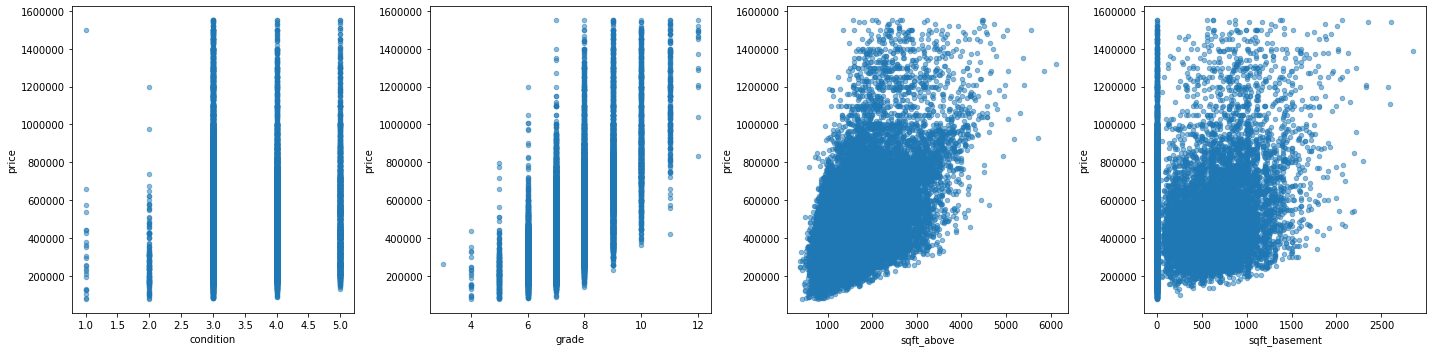

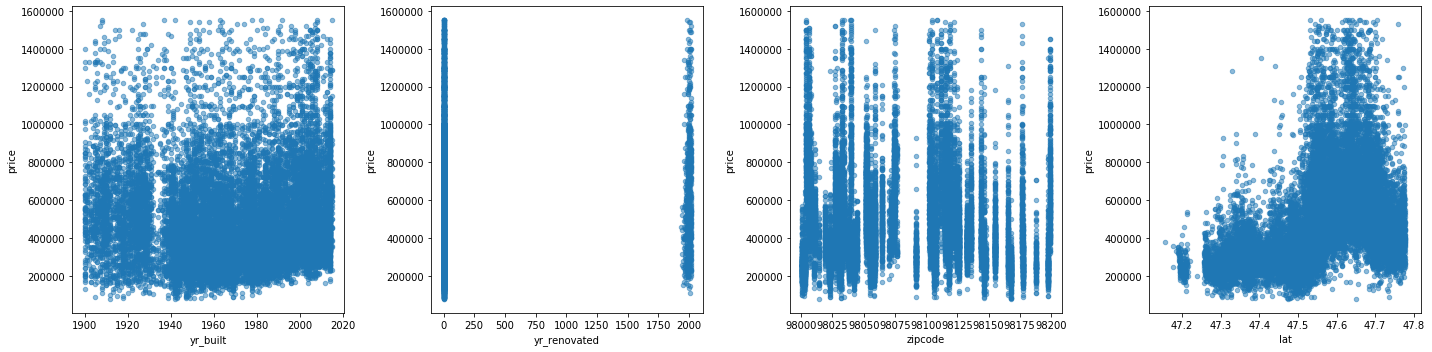

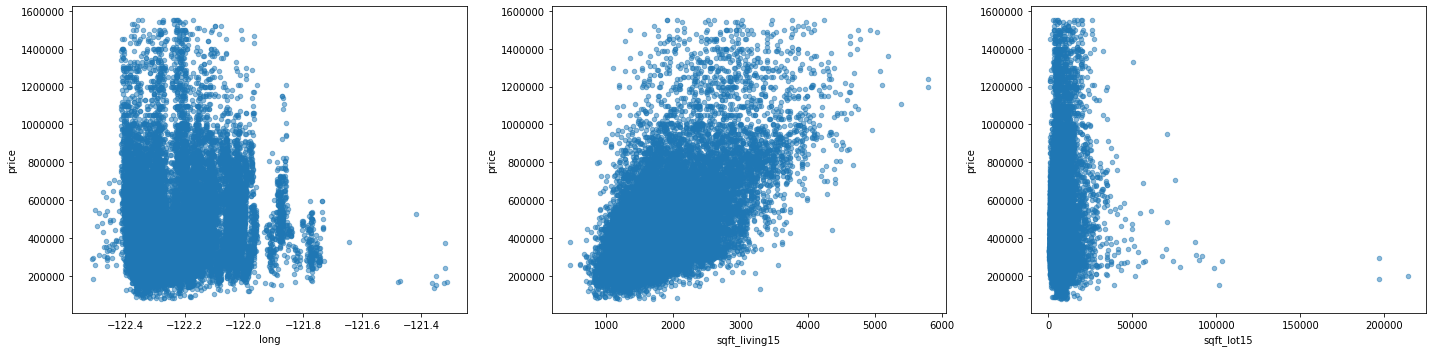

In [69]:
plot_x_y(['date', 'bedrooms', 'bathrooms', 'sqft_living'], 'price', data=houses_data)
plot_x_y(['sqft_lot', 'floors', 'waterfront', 'view'], 'price', data=houses_data)
plot_x_y(['condition', 'grade', 'sqft_above', 'sqft_basement'], 'price', data=houses_data)
plot_x_y(['yr_built', 'yr_renovated', 'zipcode', 'lat'], 'price', data=houses_data)
plot_x_y(['long', 'sqft_living15', 'sqft_lot15'], 'price', data=houses_data)

In [70]:
cont_variables = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'zipcode', 'lat', 
                  'long', 'sqft_living15', 'sqft_lot15', 'yr_renovated']
non_linear = ['date', 'yr_built', 'sqft_lot', 'long', 'sqft_lot15', 'zipcode', 'yr_renovated'] #these are clear non-linear - - do not meet linearity requiremnet

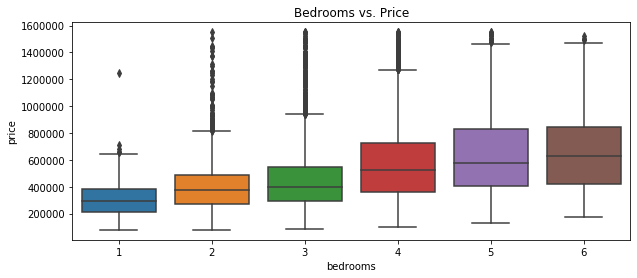

In [71]:
# evaluate cat columns for ordinal relationships - if ordinal, will treat as a single column, otherwise 
# create dummy vars

#BEDROOMS
plt.figure(figsize=(10, 4))
ax = sns.boxplot(x='bedrooms', y='price', data=houses_data)
ax.set_title('Bedrooms vs. Price')
plt.show()

In [72]:
# there is a clear ordinal relationship between the number of bedrooms and price - - will leave as a single feature

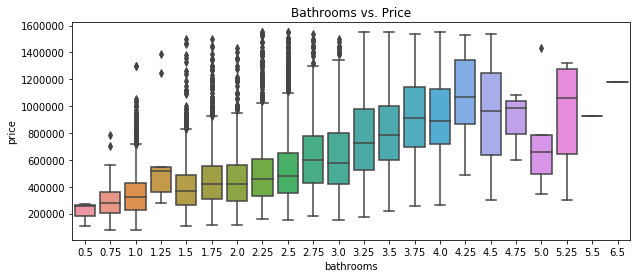

In [73]:
# BATHROOMS

plt.figure(figsize=(10, 4))
ax = sns.boxplot(x='bathrooms', y='price', data=houses_data)
plt.title('Bathrooms vs. Price')
plt.show()

In [74]:
# how many entries have more than 5 bathrooms?
houses_data.loc[houses_data['bathrooms'] > 4]['price'].count()

103

In [75]:
# there are only 103 entries with more than 4 bathrooms - - cutoff at 4 bathrooms
houses_data = houses_data.loc[houses_data['bathrooms'] <= 4]

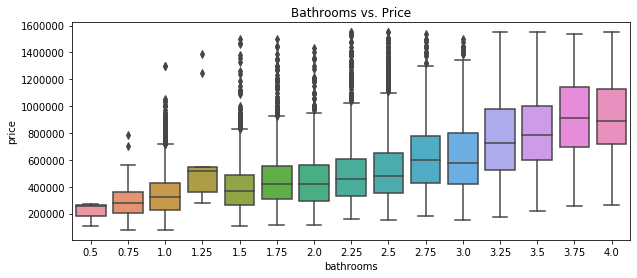

In [76]:
# replot
plt.figure(figsize=(10, 4))
ax = sns.boxplot(x='bathrooms', y='price', data=houses_data)
plt.title('Bathrooms vs. Price')
plt.show()

In [77]:
# again there appears to be an ordinal relationship between the number of bathrooms and bedrooms

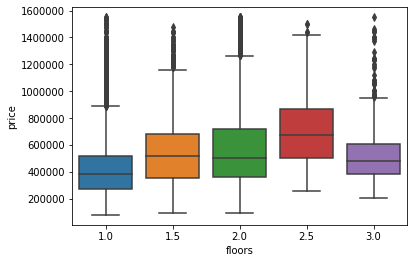

In [78]:
ax = sns.boxplot(x='floors', y='price', data=houses_data)

In [79]:
# there appears to be an ordinal relationship here

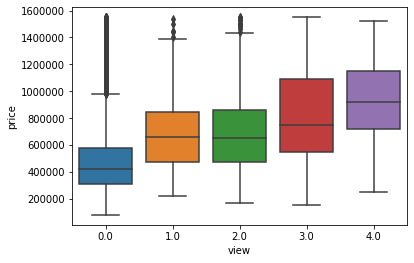

In [80]:
ax = sns.boxplot(x='view', y='price', data=houses_data)

In [81]:
# clear ordinal relationship here

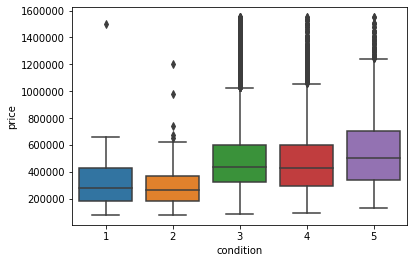

In [82]:
ax = sns.boxplot(x='condition', y='price', data=houses_data)

In [83]:
# ordinal 

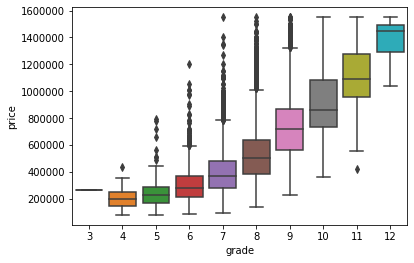

In [84]:
ax = sns.boxplot(x='grade', y='price', data=houses_data)

In [85]:
# there appears to be an ordinal relationship here - - potentially exponential?

In [86]:
houses_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [87]:
# check for multicollinearity and remove where necessary
data_pred = houses_data.iloc[:, 2:]
data_pred.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [88]:
# return only highly correlated pairs
# save absolute value of correlation matrix as data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df = data_pred.corr().abs().stack().reset_index().sort_values(0, ascending=False)

#zip the variable name columns (named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

#set index to pairs
df.set_index(['pairs'], inplace=True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace=True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates
df.drop_duplicates(inplace=True)


In [89]:
# get pairs that are more than 75% correlated
df[(df.cc>.75) & (df.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.847449
"(sqft_living15, sqft_living)",0.750702


In [90]:
# remove sqft_living as that appears correlated with both sqft_above and sqft_living15
# this is where the clean data set is split

In [91]:
clean_houses_data = houses_data.drop(['sqft_living'], axis=1)

In [92]:
clean_houses_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [93]:
# drop non-linear columns
clean_houses_data = clean_houses_data.drop(non_linear, axis=1)
clean_houses_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15'],
      dtype='object')

In [94]:
# categorical columns prior to any preprocessing
cat_origin = clean_houses_data[['waterfront']]
ordinal_cat = clean_houses_data[['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade']]

In [95]:
water_dummies = pd.get_dummies(cat_origin['waterfront'], prefix='water', drop_first=True)

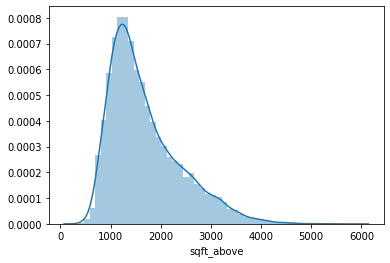

In [96]:
# log transform non-normal
sns.distplot(clean_houses_data['sqft_above'])

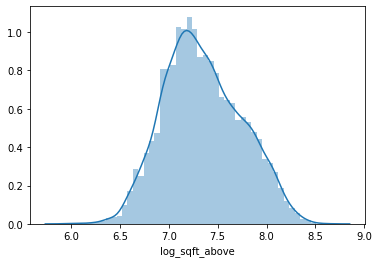

In [97]:
# this would likley benefit from log transformation
clean_houses_data['log_sqft_above'] = np.log(clean_houses_data['sqft_above'])
sns.distplot(clean_houses_data['log_sqft_above'])

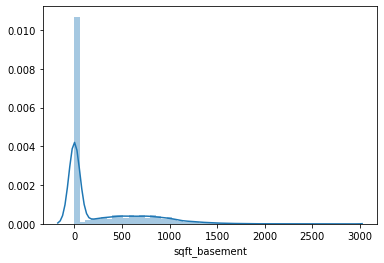

In [98]:
#BASEMENT
sns.distplot(clean_houses_data['sqft_basement'])

In [99]:
# leave this as it is for now - - there are a large number that do not have a basement (0)

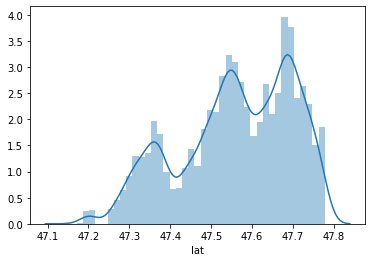

In [100]:
sns.distplot(clean_houses_data['lat'])

In [101]:
# going to leave this alone for now

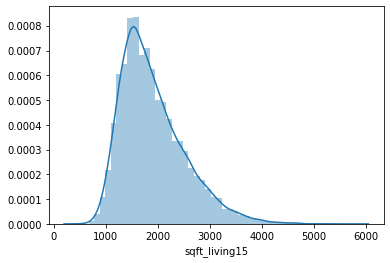

In [102]:
#sqft_living15
sns.distplot(clean_houses_data['sqft_living15'])

In [103]:
# log transform
clean_houses_data['log_sqft_living15'] = np.log(clean_houses_data['sqft_living15'])

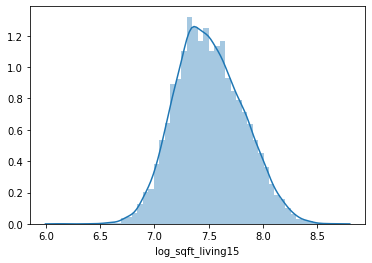

In [104]:
sns.distplot(clean_houses_data['log_sqft_living15'])

In [105]:
preprocessed = pd.concat([clean_houses_data, water_dummies], axis=1)

In [106]:
preprocessed = preprocessed.drop(['waterfront', 'sqft_living15', 'sqft_above'], axis=1)

In [107]:
y = preprocessed['price']
X = preprocessed.drop(['price'], axis=1)

In [108]:
import statsmodels.api as sm
predictors_int = sm.add_constant(X)

In [109]:
model = sm.OLS(preprocessed['price'], predictors_int).fit()

In [110]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     3221.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:37:19   Log-Likelihood:            -2.5103e+05
No. Observations:               18873   AIC:                         5.021e+05
Df Residuals:                   18861   BIC:                         5.022e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -3.243e+07   3.77e+05    -85.939      0.000   -3.32e+07   -3.17e+07
bedrooms          -9644.1140   1642.670     -5.871      0.000   -1.29e+04   -6424.332
bathrooms         -1.037e+04   2489.095     -4.164      0.000   -1.52e+04   -5486.204
floors             1.479e+04   2769.205      5.341      0.000    9361.934    2.02e+04
view               5.247e+04   1727.510     30.375      0.000    4.91e+04    5.59e+04
condition          4.809e+04   1706.989     28.172      0.000    4.47e+04    5.14e+04
grade              8.382e+04   1639.483     51.127      0.000    8.06e+04     8.7e+04
sqft_basement       108.4118      3.585     30.244      0.000     101.386     115.438
lat                6.387e+05   7875.186     81.109      0.000    6.23e+05    6.54e+05
log_sqft_above      1.55e+05   5581.918     27.774      0.000    1.44e+05    1.66e+05
log_sqft_living15  7.902e+04   5364.832     14.729      0.000    6.85e+04    8.95e+04
water_1.0           1.81e+05    2.1e+04      8.620      0.000     1.4e+05    2.22e+05
==============================================================================
Omnibus:                     4255.347   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13231.850
Skew:                           1.155   Prob(JB):                         0.00
Kurtosis:                       6.389   Cond. No.                     1.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [111]:
# try to improve model results

In [112]:
# houses data is the clean data set prior to removing any multi-collineariy columns - - revert back to this and see
# if we can improve results

In [113]:
houses_data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [114]:
# remove sqft_living to remove multi-collinearity

In [115]:
clean_houses_data = houses_data.drop(['sqft_living'], axis=1)

In [116]:
# drop non-linear columns
clean_houses_data = clean_houses_data.drop(non_linear, axis=1)
clean_houses_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15'],
      dtype='object')

In [117]:
# categorical columns prior to any preprocessing
cat_origin = clean_houses_data[['waterfront']]
water_dummies = pd.get_dummies(cat_origin['waterfront'], prefix='water', drop_first=True)

In [118]:
# going to transform sqft_below to categorical (treat anything >0 as a basement and anything else as no basement)

In [119]:
clean_houses_data.loc[clean_houses_data['sqft_basement'] == 0]['price'].count()

11475

In [120]:
clean_houses_data.loc[clean_houses_data['sqft_basement'] > 0]['price'].count()

7398

In [121]:
clean_houses_data.loc[clean_houses_data['sqft_basement'] > 0, 'sqft_basement'] = 1

In [122]:
clean_houses_data['sqft_basement'].nunique()

2

In [123]:
# one hot encode these
basement_origin = clean_houses_data[['sqft_basement']]
basement_dummies = pd.get_dummies(basement_origin['sqft_basement'], prefix='basement', drop_first=True)

In [124]:
# log transform non-normal
clean_houses_data['log_sqft_above'] = np.log(clean_houses_data['sqft_above'])
clean_houses_data['log_sqft_living15'] = np.log(clean_houses_data['sqft_living15'])

In [125]:
preprocessed = pd.concat([clean_houses_data, water_dummies, basement_dummies], axis=1)

In [126]:
preprocessed.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15', 'log_sqft_above', 'log_sqft_living15', 'water_1.0',
       'basement_1.0'],
      dtype='object')

In [127]:
preprocessed = preprocessed.drop(['waterfront', 'sqft_living15', 'sqft_above'], axis=1)

In [128]:
y = preprocessed['price']
X = preprocessed.drop(['price'], axis=1)

In [129]:
predictors_int = sm.add_constant(X)
model = sm.OLS(y, predictors_int).fit()

In [130]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     3169.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:37:20   Log-Likelihood:            -2.5113e+05
No. Observations:               18873   AIC:                         5.023e+05
Df Residuals:                   18861   BIC:                         5.024e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -3.257e+07   3.79e+05    -85.881      0.000   -3.33e+07   -3.18e+07
bedrooms          -3756.1310   1607.634     -2.336      0.019   -6907.239    -605.023
bathrooms         -5819.5666   2485.639     -2.341      0.019   -1.07e+04    -947.490
floors             4409.4483   2709.393      1.627      0.104    -901.206    9720.103
view               5.718e+04   1714.929     33.342      0.000    5.38e+04    6.05e+04
condition          5.158e+04   1707.353     30.213      0.000    4.82e+04    5.49e+04
grade              8.415e+04   1652.409     50.928      0.000    8.09e+04    8.74e+04
sqft_basement      3.825e+04   1438.267     26.592      0.000    3.54e+04    4.11e+04
lat                6.398e+05   7926.508     80.722      0.000    6.24e+05    6.55e+05
log_sqft_above     1.569e+05   5799.926     27.060      0.000    1.46e+05    1.68e+05
log_sqft_living15  8.556e+04   5373.721     15.923      0.000     7.5e+04    9.61e+04
water_1.0          1.728e+05   2.11e+04      8.189      0.000    1.31e+05    2.14e+05
basement_1.0       3.825e+04   1438.267     26.592      0.000    3.54e+04    4.11e+04
==============================================================================
Omnibus:                     4345.786   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13329.240
Skew:                           1.185   Prob(JB):                         0.00
Kurtosis:                       6.367   Cond. No.                     3.76e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.28e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [131]:
# results are actually slightly worse when treating the sqft_below column as a cat column
# try log normalizing this column to see if it helps
clean_houses_data = houses_data.drop(['sqft_living'], axis=1)

# drop non-linear columns
clean_houses_data = clean_houses_data.drop(non_linear, axis=1)
clean_houses_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15'],
      dtype='object')

In [132]:
# categorical columns prior to any preprocessing
cat_origin = clean_houses_data[['waterfront']]
water_dummies = pd.get_dummies(cat_origin['waterfront'], prefix='water', drop_first=True)

In [133]:
# log transform non-normal
clean_houses_data['log_sqft_above'] = np.log(clean_houses_data['sqft_above'])
clean_houses_data['log_sqft_living15'] = np.log(clean_houses_data['sqft_living15'])

In [134]:
# log transform price

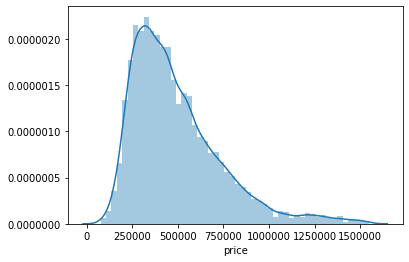

In [135]:
sns.distplot(clean_houses_data['price'])

In [136]:
clean_houses_data['log_price'] = np.log(clean_houses_data['price'])

In [137]:
preprocessed = pd.concat([clean_houses_data, water_dummies], axis=1)

In [138]:
preprocessed.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15', 'log_sqft_above', 'log_sqft_living15', 'log_price',
       'water_1.0'],
      dtype='object')

In [139]:
preprocessed = preprocessed.drop(['waterfront', 'price', 'sqft_basement', 'sqft_living15', 'sqft_above'], axis=1)

In [140]:
y = preprocessed['log_price']
X = preprocessed.drop(['log_price'], axis=1)

In [141]:
predictors_int = sm.add_constant(X)
model = sm.OLS(y, predictors_int).fit()

In [142]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4304.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:37:20   Log-Likelihood:                -1527.2
No. Observations:               18873   AIC:                             3076.
Df Residuals:                   18862   BIC:                             3163.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -67.9549      0.681    -99.732      0.000     -69.291     -66.619
bedrooms              0.0171      0.003      6.073      0.000       0.012       0.023
bathrooms             0.0547      0.004     13.140      0.000       0.047       0.063
floors               -0.0003      0.005     -0.055      0.956      -0.010       0.009
view                  0.0910      0.003     29.649      0.000       0.085       0.097
condition             0.1056      0.003     34.316      0.000       0.100       0.112
grade                 0.1559      0.003     53.171      0.000       0.150       0.162
lat                   1.6038      0.014    113.024      0.000       1.576       1.632
log_sqft_above        0.1443      0.009     15.904      0.000       0.127       0.162
log_sqft_living15     0.2514      0.010     26.152      0.000       0.233       0.270
water_1.0             0.3501      0.038      9.193      0.000       0.275       0.425
==============================================================================
Omnibus:                      186.014   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              263.155
Skew:                           0.124   Prob(JB):                     7.19e-58
Kurtosis:                       3.523   Cond. No.                     1.77e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [143]:
# improvement over where the model was previously
# log normalize lat
clean_houses_data = houses_data.drop(['sqft_living'], axis=1)

# drop non-linear columns
clean_houses_data = clean_houses_data.drop(non_linear, axis=1)
clean_houses_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15'],
      dtype='object')

In [144]:
# categorical columns prior to any preprocessing
cat_origin = clean_houses_data[['waterfront']]
water_dummies = pd.get_dummies(cat_origin['waterfront'], prefix='water', drop_first=True)

In [145]:
#log normalize
clean_houses_data['log_sqft_above'] = np.log(clean_houses_data['sqft_above'])
clean_houses_data['log_sqft_living15'] = np.log(clean_houses_data['sqft_living15'])
clean_houses_data['log_price'] = np.log(clean_houses_data['price'])

In [146]:
# log normalize lat
clean_houses_data['log_lat'] = np.log(clean_houses_data['lat'])

In [147]:
preprocessed = pd.concat([clean_houses_data, water_dummies], axis=1)

In [148]:
preprocessed = preprocessed.drop(['waterfront', 'price', 'sqft_basement', 'sqft_living15', 
                                  'sqft_above', 'lat'], axis=1)

In [149]:
y = preprocessed['log_price']
X = preprocessed.drop(['log_price'], axis=1)

In [150]:
predictors_int = sm.add_constant(X)
model = sm.OLS(y, predictors_int).fit()

In [151]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4309.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:37:20   Log-Likelihood:                -1520.0
No. Observations:               18873   AIC:                             3062.
Df Residuals:                   18862   BIC:                             3148.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -286.2329      2.608   -109.750      0.000    -291.345    -281.121
bedrooms              0.0170      0.003      6.071      0.000       0.012       0.023
bathrooms             0.0547      0.004     13.149      0.000       0.047       0.063
floors               -0.0003      0.005     -0.073      0.942      -0.010       0.009
view                  0.0910      0.003     29.651      0.000       0.085       0.097
condition             0.1056      0.003     34.327      0.000       0.100       0.112
grade                 0.1558      0.003     53.168      0.000       0.150       0.162
log_sqft_above        0.1445      0.009     15.937      0.000       0.127       0.162
log_sqft_living15     0.2513      0.010     26.154      0.000       0.233       0.270
log_lat              76.2700      0.674    113.131      0.000      74.949      77.591
water_1.0             0.3502      0.038      9.199      0.000       0.276       0.425
==============================================================================
Omnibus:                      186.453   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              264.072
Skew:                           0.124   Prob(JB):                     4.54e-58
Kurtosis:                       3.524   Cond. No.                     2.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [152]:
# improvement over where the model was previously
# log normalize lat
clean_houses_data = houses_data.drop(['sqft_living'], axis=1)

# drop non-linear columns
clean_houses_data = clean_houses_data.drop(non_linear, axis=1)
clean_houses_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15'],
      dtype='object')

In [153]:
# categorical columns prior to any preprocessing
cat_origin = clean_houses_data[['waterfront']]
water_dummies = pd.get_dummies(cat_origin['waterfront'], prefix='water', drop_first=True)

In [154]:
clean_houses_data['log_sqft_above'] = np.log(clean_houses_data['sqft_above'])
clean_houses_data['log_sqft_living15'] = np.log(clean_houses_data['sqft_living15'])
clean_houses_data['log_price'] = np.log(clean_houses_data['price'])
clean_houses_data['log_lat'] = np.log(clean_houses_data['lat'])

In [155]:
# log_lat could be quadratic as well as grade
# grade should be ^2
# log_lat will be ^3+

In [156]:
# polynomials and interactions